In [66]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd

import matplotlib.pyplot as plt


from optimizers import RRAMOptimizer, ContinuousOptimizer


# Step 1: Generate Synthetic Data
n_samples = 10000
X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=1.5, random_state=42)


In [67]:
device = torch.device('cuda')
print(device)

cuda


In [68]:

# def load_data(file_path, column, rows=None):
#     """Generic function to load data from an Excel file."""
#     df = pd.read_excel(file_path)
#     return list(df[column][:rows]) if rows else list(df[column])

# DATASETS = {
#     "pradeep": ("data/data_P_D_pradeep_sachan.xlsx", "potentiation (mS)", 30),
#     "vivek": ("data/new_data_50_pulses.xlsx", "Potentiation", None),
#     "himanshu": ("data/himanshu_data_128_cycles.xlsx", "Conductance", 128)
# }

# # Select potentiation data
# data_choice = "vivek" 

# finite_set = load_data(*DATASETS.get(data_choice, (None, None, None)))

# print(finite_set)



def load_data(file_path, column, rows=None):
    """Generic function to load data from an Excel file."""
    df = pd.read_excel(file_path)
    return list(df[column][rows]) if rows else list(df[column])

POTENTIATION_DATASETS = {
    "pradeep": ("data/data_P_D_pradeep_sachan.xlsx", "potentiation (mS)", range(30)),
    "pradeep_new_data":("data/pradeep_new_data.xlsx", "Conductance", range(680)),
    "vivek": ("data/new_data_50_pulses.xlsx", "Potentiation", None),
    "himanshu": ("data/himanshu_data_128_cycles.xlsx", "Potentiation", range(128)),
    "rahul":("data/64_pot_dep_1.xlsx", "Depression", range(64))
}
DEPRESSION_DATASETS = {
    "pradeep": ("data/data_P_D_pradeep_sachan.xlsx", "Depression", None),
    "pradeep_new_data":("data/pradeep_new_data.xlsx", "Conductance", range(680, 1358)),
    "vivek": ("data/new_data_50_pulses.xlsx", "Depression", None),
    "himanshu": ("data/himanshu_data_128_cycles.xlsx", "Depression", None),
    "rahul":("data/64_pot_dep_1.xlsx", "Depression", range(63, 128))
}
# Select potentiation data
data_choice = "rahul" 

potentiation_conductances = load_data(*POTENTIATION_DATASETS.get(data_choice, (None, None, None)))
depression_conductances = load_data(*DEPRESSION_DATASETS.get(data_choice, (None, None, None)))




In [69]:
def adjusted_list(values, flag = True):
    new_values = values[:1]  # Start with the first element
    for i in range(1, len(values)):
        if flag:
            new_values.append(max(new_values[-1], values[i]))  # Ensure non-decreasing order
        else:
            new_values.append(min(new_values[-1], values[i]))  # Ensure non-decreasing order

    return new_values

adjusted_potentiation = adjusted_list(potentiation_conductances)
adjusted_depression = adjusted_list(depression_conductances, False)


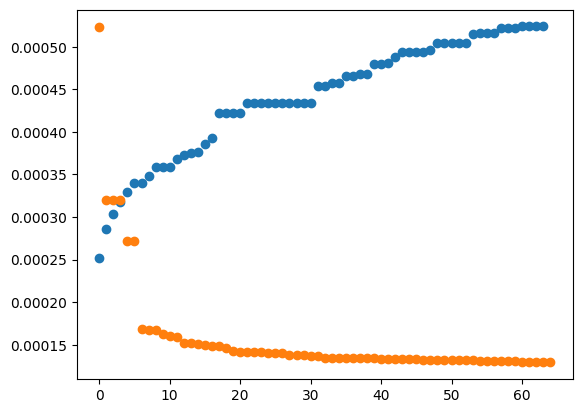

In [70]:
plt.scatter([i for i in range(len(potentiation_conductances))], adjusted_potentiation)
plt.scatter([i for i in range(len(depression_conductances))], adjusted_depression)

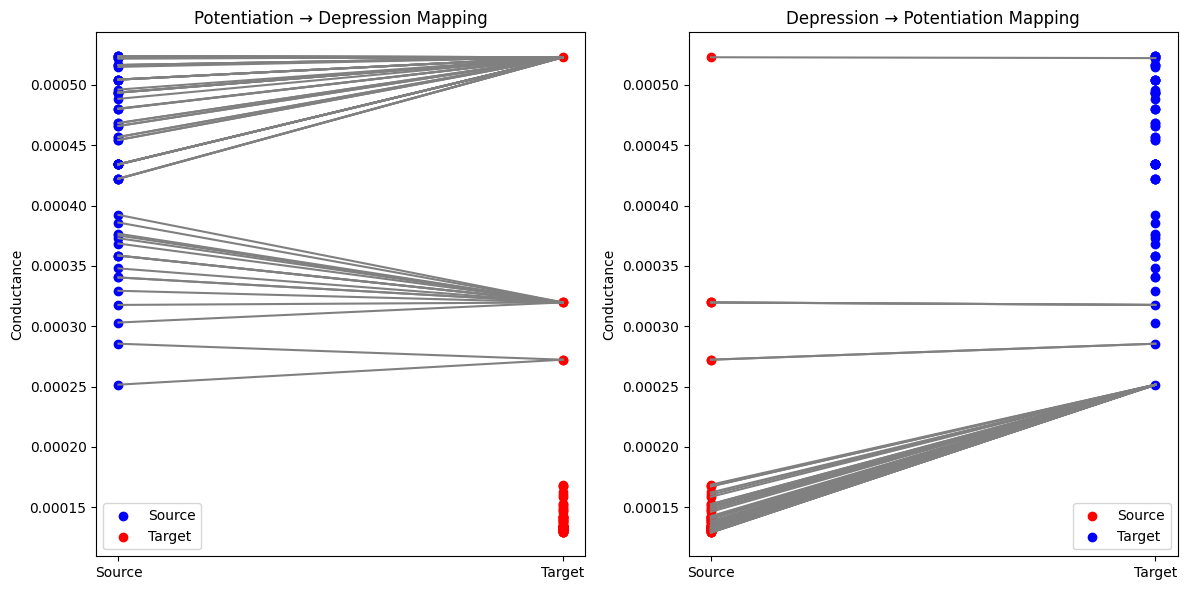

In [71]:
import matplotlib.pyplot as plt
import numpy as np


def map_to_nearest_indices(given_list, reference_list):
    def safe_tensor_conversion(data, dtype=torch.float32):
        if isinstance(data, torch.Tensor):
            return data.clone().detach().to(dtype)  # Clone if it's already a tensor
        return torch.tensor(data, dtype=dtype)  # Convert if it's a list or other type

    given_tensor = safe_tensor_conversion(given_list)
    reference_tensor = safe_tensor_conversion(reference_list)
    indices = torch.abs(reference_tensor.unsqueeze(0) - given_tensor.unsqueeze(-1)).argmin(dim=-1)
            
    return torch.tensor(indices.tolist())

# Example data
# potentiation_conductances = [0.1, 0.2, 0.3, 0.4, 0.5]
# depression_conductances = [0.15, 0.25, 0.35, 0.45, 0.55]

# # Mappings
potentiation_to_depression_mapping = map_to_nearest_indices(adjusted_potentiation, adjusted_depression) # Index-wise mapping
depression_to_potentiation_mapping = map_to_nearest_indices(adjusted_depression, adjusted_potentiation)  # Reverse mapping

# Set positions for plotting
potentiation_x = np.zeros(len(adjusted_potentiation))
depression_x = np.ones(len(adjusted_depression))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Two subplots side by side

# Function to plot mappings
def plot_mapping(ax, x1, y1, x2, y2, mapping, title, color1, color2):
    ax.scatter(x1, y1, color=color1, label="Source")
    ax.scatter(x2, y2, color=color2, label="Target")

    # Draw mapping lines
    for i, target_idx in enumerate(mapping):
        ax.plot([x1[0], x2[0]], [y1[i], y2[target_idx]], 'gray')

    ax.set_xticks([x1[0], x2[0]])
    ax.set_xticklabels(["Source", "Target"])
    ax.set_ylabel("Conductance")
    ax.set_title(title)
    ax.legend()

# First subplot: Potentiation → Depression
plot_mapping(axs[0], [0] * len(adjusted_potentiation), adjusted_potentiation, 
             [1] * len(adjusted_depression), adjusted_depression, 
             potentiation_to_depression_mapping, 
             "Potentiation → Depression Mapping", "blue", "red")

# Second subplot: Depression → Potentiation
plot_mapping(axs[1], [0] * len(adjusted_depression), adjusted_depression, 
             [1] * len(adjusted_potentiation), adjusted_potentiation, 
             depression_to_potentiation_mapping, 
             "Depression → Potentiation Mapping", "red", "blue")

plt.tight_layout()
plt.show()

In [72]:

# Standardize the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)


In [73]:

# Step 2: Define the MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 16)  # Input layer (2 features) to hidden layer (16 neurons)
        self.fc2 = nn.Linear(16, 2)   # Hidden layer (16 neurons) to output layer (2 classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = self.fc2(x)               # No activation for output layer
        return x


In [74]:

# Create the model
model = MLP().to(device)
# Step 3: Train the Model
criterion = nn.CrossEntropyLoss()  # Loss function
# optimizer = FiniteSetOptimizer(model.parameters(),finite_set=finite_set, tau=0.05)
# optimizer = DiscreteStateOptimizer(model.parameters(), conductance_list=finite_set, tau=0.05)
# optimizer = RRAMOptimizer(model.parameters(), adjusted_potentiation, adjusted_depression, 0.05)

optimizer = ContinuousOptimizer(model.parameters(), 
                                potentiation=torch.tensor(adjusted_potentiation).to(device), 
                                depression=torch.tensor(adjusted_depression).to(device), 
                                potentiation_degree=5,
                                depression_degree=3,
                                tau=0.05)


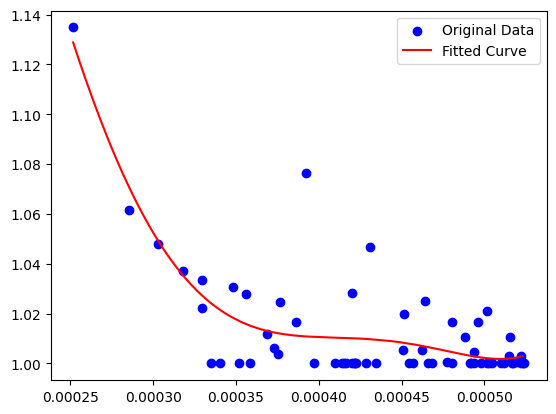

In [75]:
x_dense = torch.linspace(optimizer.min_conductance, optimizer.max_conductance, steps=1000)
y_pred = optimizer.potentiation_model.predict(x_dense)

# Plot original points and fitted curve
plt.scatter(potentiation_conductances, optimizer.potentiation_g_by_g0.cpu(), label="Original Data", color="blue")
plt.plot(x_dense.cpu(), y_pred.cpu(), label="Fitted Curve", color="red")
plt.legend()
plt.show()

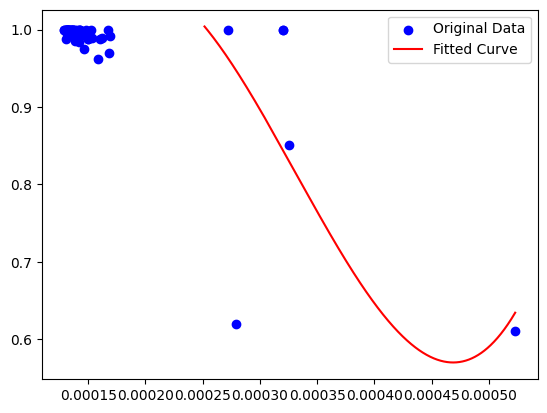

In [76]:
# Example data (replace with actual x, y tensors)
# x = torch.linspace(0, 10, steps=10)
# y = torch.sin(x) + 0.1 * torch.randn_like(x)  # Noisy data

# x = torch.tensor(depression)
# y = torch.tensor(depression_g_by_g0)
# Fit the model

# Predict values for a smooth curve
# x_dense = torch.linspace(optimizer.min_conductance, optimizer.max_conductance, steps=1000)
x_dense = torch.linspace(optimizer.max_conductance, optimizer.min_conductance, steps=1000)
y_pred = optimizer.depression_model.predict(x_dense)

# Plot original points and fitted curve
plt.scatter(depression_conductances, optimizer.depression_g_by_g0.cpu(), label="Original Data", color="blue")
plt.plot(x_dense.cpu(), y_pred.cpu(), label="Fitted Curve", color="red")
plt.legend()
plt.show()

In [77]:


# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [2/20], Loss: 0.3307
Epoch [4/20], Loss: 0.1849
Epoch [6/20], Loss: 0.1578
Epoch [8/20], Loss: 0.1428
Epoch [10/20], Loss: 0.1317
Epoch [12/20], Loss: 0.1263
Epoch [14/20], Loss: 0.1213
Epoch [16/20], Loss: 0.1167
Epoch [18/20], Loss: 0.1148
Epoch [20/20], Loss: 0.1123


Accuracy: 99.98%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[1989    0]
 [   1 2010]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1989
           1       1.00      1.00      1.00      2011

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



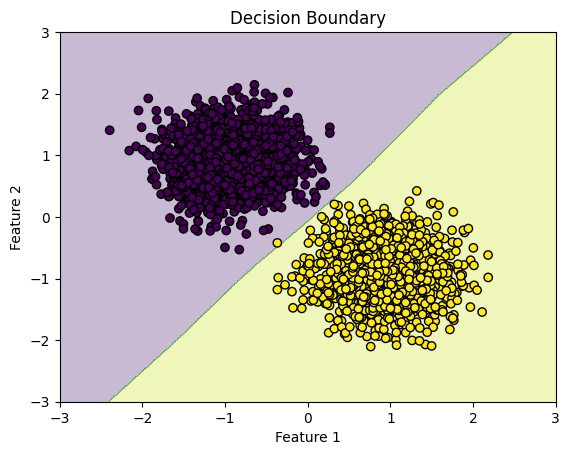

In [78]:

# Step 4: Evaluate the Model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test_tensor.cpu(), predicted.cpu())
    precision = precision_score(y_test_tensor.cpu(), predicted.cpu())
    recall = recall_score(y_test_tensor.cpu(), predicted.cpu())
    f1 = f1_score(y_test_tensor.cpu(), predicted.cpu())
    cm = confusion_matrix(y_test_tensor.cpu(), predicted.cpu())
    
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    print(cm)
    print('\nClassification Report:')
    print(classification_report(y_test_tensor.cpu(), predicted.cpu()))

# Plotting the decision boundary
xx, yy = np.meshgrid(np.linspace(-3, 3, 1000), np.linspace(-3, 3, 1000))
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
with torch.no_grad():
    Z = model(grid)
    _, Z = torch.max(Z.data, 1)
Z = Z.cpu().numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
